# Context

If trying to predict the occurance of slow waves using local scale motion patterns one must make sure to use data from a timeframe before the actual onset of the rising peak in activation. Otherwise one would not use data that shows possible precoditions that potentially cause slow waves but the slow wave itself.

# Imports

In [2]:
from skimage import io
import skimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
import pickle

In [3]:
import imageio
from pathlib import Path
from matplotlib.pyplot import show
from argparse import ArgumentParser

from pyoptflow import HornSchunck, getimgfiles
from pyoptflow.plots import compareGraphs

In [4]:
from PIL import Image
import os
from scipy.signal import argrelextrema
from skimage import exposure

In [5]:
import matplotlib
import matplotlib.animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [6]:
np.array(np.clip([300],0,255), dtype=np.uint8)

array([255], dtype=uint8)

### Import our custom utility methods

In [2]:
import sys
%reload_ext autoreload
%autoreload 2
sys.path.append('..')

from utils.visualization_tools import *
import utils.visualization_tools
from utils.data_transformations import *
import utils.data_transformations
from utils.diverse import *
import utils.diverse

The following modules are available

In [3]:
print_module_methods(utils.diverse)

print_module_methods(module)



In [4]:
print_module_methods(utils.visualization_tools)

display_combined(u, v, Inew, scale=100, quivstep=3, fig=None, ax=None, figsize=(10, 10), vmin=0, vmax=1)



In [5]:
print_module_methods(utils.data_transformations)

HornSchunck(im1: numpy.ndarray, im2: numpy.ndarray, *, alpha: float = 0.001, Niter: int = 8, verbose: bool = False) -> Tuple[numpy.ndarray, numpy.ndarray]

apply_mask(frames, mask)

clipped_adaptive(tensor, clipping=0.8)

fourier(signal, sampling_rate=100)

framewise_difference(frames, pixelwise_mean, bigdata=False)

gaussian_filter(input, sigma, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

getimgfiles(stem: pathlib.Path, pat: str) -> list

horn_schunck(tensor, frames=None)

maxima(vector, pre_smoothing=100, minval=0)

normalize(frames)

substract_pixel_min(tensor)

uniform_filter(input, size=3, output=None, mode='reflect', cval=0.0, origin=0)



# Load data and inspect a frame of the raw data

In [24]:
from pathlib import Path
source_folder = os.path.join(Path(os.getcwd()).parent, "source_data")

In [25]:
frames = skimage.io.imread(os.path.join(source_folder,"runstart16_X1.tif"))

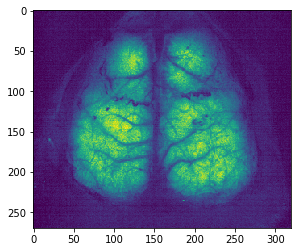

In [26]:
plt.imshow(frames[0,:,:])

In [27]:
frames.shape

(12255, 270, 320)

In [28]:
frames = frames[:1000,:,:]

# Preprocessing

Here I calculate the difference from pixelwise mean as well as a smoothed version that promised to increase the signal to noise ratio.

In [29]:
mean = np.mean(frames,axis=0)#pixelwise mean

In [30]:
difference = normalize(framewise_difference(frames, mean, bigdata=False))

In [31]:
smooth = normalize(gaussian_filter(substract_pixel_min(difference), 1))

In [32]:
framewise_normalized = (np.array([normalize(frame) for frame in smooth]))

In [33]:
smoother = normalize(uniform_filter(framewise_normalized,[10,20,20]))# [20,30,30]))

In [34]:
details = framewise_normalized-smoother

In [35]:
details = np.array([normalize(frame) for frame in smooth])

In [36]:
#details = normalize(details)

In [37]:
contrast_enhanced = clipped_adaptive(details)

# Determine onset of slow wave events in an objective manner

To determine the onset of spreading activation objectively, first the upper decentile is computed for each frame. Second the resulting vector is slighly smoothened to reduce the impact of noise in the signal. A gaussian kernel of size 10 is used in this respect. Smooting the curve allows to compute local maxima to determine the peak of individual slow waves. As only slight smoothing is applied maxima that occur at low levels of activation prevail. They are removed by selecting those local maxima that relate to peaks with a value above the median.

In [35]:
frame_means = [np.mean(f) for f in smooth]
frame_max = [np.max(f) for f in smooth]
upper_decentile = [np.quantile(f,0.9) for f in smooth]
smooth_max = gaussian_filter(frame_max,10)
upper_decentile_smooth = gaussian_filter(upper_decentile,10)

In [36]:
maxs = maxima(np.array(upper_decentile_smooth),0,np.median(upper_decentile_smooth))

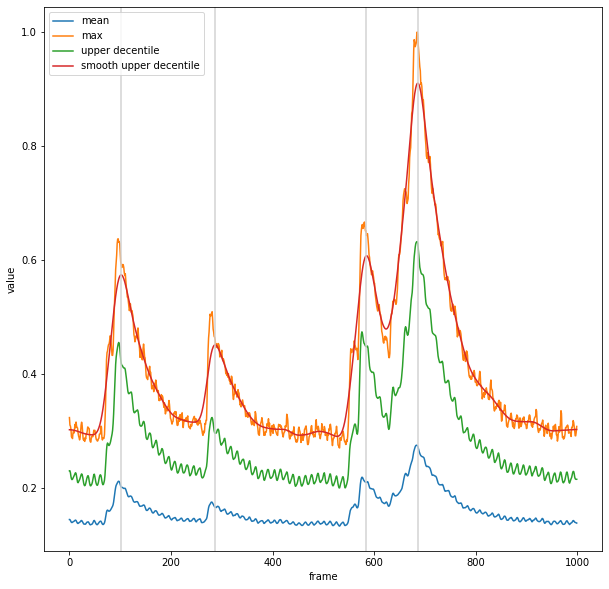

In [37]:
%matplotlib inline
fig, ax = plt.subplots(1,figsize=(10,10))
ax.plot(frame_means, label="mean")
ax.plot(frame_max, label="max")
ax.plot(upper_decentile, label = "upper decentile")
ax.plot(smooth_max, label="smooth upper decentile")
ax.legend(loc="upper left")
ax.set_xlabel("frame")
ax.set_ylabel("value")
for x in maxs:
    ax.axvline(x, c="lightgray")

To determine the minimal threshold that indicates a slow wave the following procedure is used. The estimate for the lowest feasible threshold is initialized to the median. Then it is lowered iteratively until the number of detected peaks changes.


In [38]:
def zero_crossings(a):
    return np.where(np.diff(np.sign(a)))[0]
def n_zero_crossings(vector, threshold):
    a = (vector >threshold)-.5
    return len(zero_crossings(a))

In [39]:
epsilon = .01
min_peak = np.min(upper_decentile_smooth[maxs])-epsilon

In [40]:
n_zero_cross = n_zero_crossings(upper_decentile_smooth,min_peak)
lowest_feasible_threshold = None

In [41]:
for x in np.linspace(min_peak,0,100):
    if n_zero_crossings(upper_decentile_smooth,x)!=n_zero_cross:
        lowest_feasible_threshold = x
        break

In [42]:
onsets = zero_crossings((upper_decentile_smooth>lowest_feasible_threshold+epsilon)-.51)

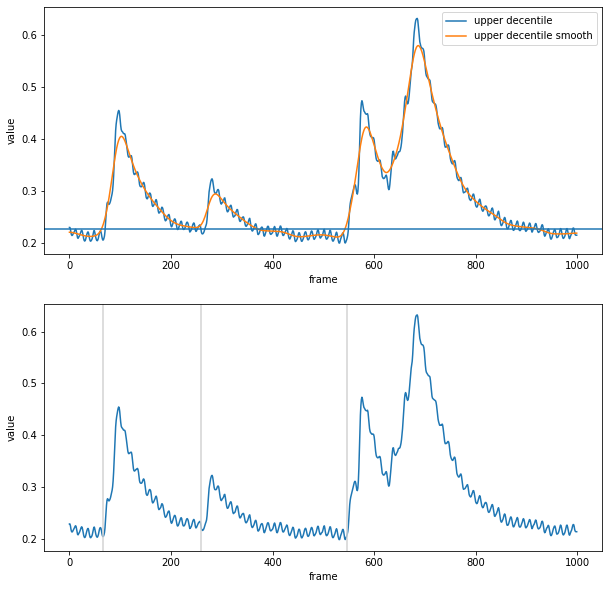

In [43]:
%matplotlib inline
fig, ax = plt.subplots(2,figsize=(10,10))
ax[0].plot(upper_decentile, label = "upper decentile")
ax[0].plot(upper_decentile_smooth, label = "upper decentile smooth")
ax[0].legend()
ax[0].axhline(lowest_feasible_threshold)
ax[0].set_xlabel("frame")
ax[0].set_ylabel("value")

ax[1].plot(upper_decentile)
ax[1].set_xlabel("frame")
ax[1].set_ylabel("value")

for x in onsets[::2]:
    ax[1].axvline(x, c="lightgray")

There is a frequency of 16.43 Hz
This is very close to 100/6 or 16.67


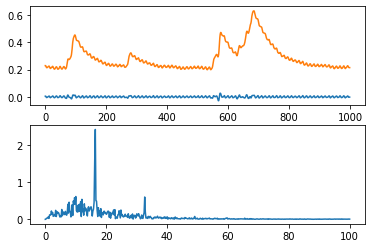

In [182]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

signal = upper_decentile-gaussian_filter(upper_decentile,3)
x, freq = fourier(signal)

fig, ax = plt.subplots(2)
ax[0].plot(signal)
ax[0].plot(upper_decentile)
ax[1].plot(x,freq)

peak_frequency = np.round(x[np.where(freq==np.max(freq))][0],2)
print("There is a frequency of " + str(peak_frequency) + " Hz")
print("This is very close to 100/6 or " + str(np.round(100/6,2)))

There is a strong frequency compinent at 100/6 Hz. It could relate to an artifact. One could try to filter the source of the signal and/or try to eliminate it to increase the signal quality.

# Is the maximal value of frames correlated with the upper decentile?

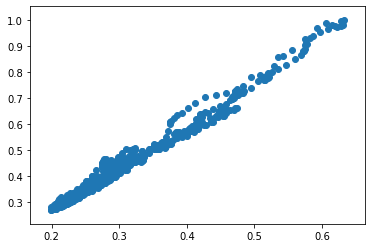

In [148]:
plt.scatter(upper_decentile, frame_max)

There is no systematic error (trend) for the timeseries of activation (luminance difference from mean).

The upper decentile and the maximal value correlate strongly. The images are not affected by single pixel outliers (non-gaussian noise). Hence, a strategy of detecting slow-wave events based on (local maxima of) maximal values appears feasable.

# Conclusion

One could find the onset of up-states during slow wave anesthesia by thresholding. The lowest feasible threshold can be determined automatically using the suggested approach. Decomposing frequencies to filter a potential artifact in the signal at 100/6 Hz can further improve the signal qualtity and allow for more accurate means to find the threshold (If it relates to a neural signal one could identify the source).

The approach is yet to be implemented in a utility method.